## Tiltmeter ALL Overview

### Import Libraries

In [2]:
import os
import obspy
import matplotlib.pyplot as plt
import pandas as pd

from numpy import arange, linspace, sqrt, diff, nan, gradient, nanmax
from pandas import read_csv, DataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.ma import filled, isMaskedArray, masked
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from obspy import UTCDateTime
from pathlib import Path

from andbro__querrySeismoData import __querrySeismoData
from andbro__get_seconds import __get_seconds
from andbro__readYaml import __readYaml
from andbro__get_timeaxis import __get_timeaxis

In [3]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

### Define Functions

In [4]:
def __makeplot(pt, bt, config):
    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    for i in range(3):
        
        axes[i,0].plot(pt[i].times()/60, pt[i].data)
        axes[i,1].plot(bt[i].times()/60, bt[i].data)
        
        axes[i,0].grid()
        axes[i,1].grid()
        
    axes[2,0].set_xlabel("Time (min)")
    axes[2,1].set_xlabel("Time (min)")
    
    axes[0,0].set_ylabel("$\Omega$ (rad)")
    axes[1,0].set_ylabel("$\Omega$ (rad)")
    axes[2,0].set_ylabel("Temp (°C)")
    
    axes[0,1].set_ylabel("$\Omega$ (rad)")
    axes[1,1].set_ylabel("$\Omega$ (rad)")
    axes[2,1].set_ylabel("Temp (°C)")
    
    return fig 

### Configurations

In [22]:
## configurations
config={}

path = "/home/andbro/Desktop/tiltmeter/"
# path2 = '/home/andbro/Desktop/tiltmeter/WETTER/*ex'

config['save'] = False

#config['tbeg'] = UTCDateTime("2022-12-20 00:00")

config['tbeg'] = UTCDateTime("2021-03-10 00:00")
config['tend'] = UTCDateTime("2023-05-31 00:00")


# config['seed_id'] = ["BW.TROMY..MA*", "BW.ROMYT..MA*", "BW.DROMY..LA*"]

config['repository'] = 'george'
config['datapath'] =  None

config['name'] = 'tiltmeter'
config['set_filter'] = 'n'

## specify path to SDS data archive
config['path_to_data'] = archive_path+"romy_archive/"
config['path_to_data'] = data_path+"TiltmeterDataBackup/Tilt_downsampled/"


## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter.conf")

## correction of offset (e.g. reset mass)
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")

## correction for temperature trends
## based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")
## based on WSX
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction_new.yml")



In [23]:
def __plot_all_tilt(st1, st2, st3):

    from datetime import datetime
    
    NN=3
    
    fig, ax = plt.subplots(NN,1, figsize=(15,8), sharex=True)

    font = 14
    
    tilt_scaling, tilt_unit = 1e-6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"
    
    ax[0].plot(st1.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*N")[0].data/tilt_scaling, label="TROMY")
    ax[0].plot(st2.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*N")[0].data/tilt_scaling, label="ROMYT")
    ax[0].plot(st3.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*N")[0].data/tilt_scaling, label="BROMY")

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st2.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st3.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*E")[0].data/tilt_scaling)

    ax[2].plot(st1.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*T")[0].data)
    ax[2].plot(st2.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*T")[0].data)
    ax[2].plot(st3.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*T")[0].data)

    ax[0].set_ylabel(f"N ({tilt_unit})", fontsize=font)
    ax[1].set_ylabel(f"E ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"T (°C)", fontsize=font)
#     ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    for o in range(3):
        ax[o].grid()
    
    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.7, 1.1), ncol=3, framealpha=1)
    
    tcks= ax[NN-1].get_xticks()
    tcklbls = [datetime.fromtimestamp(t*time_scaling+datetime(2019,1,1).timestamp()).strftime("%Y-%m-%d") for t in tcks]
    ax[NN-1].set_xticklabels(tcklbls)
    
    plt.show();
    return fig

### Load Tiltmeter Data

In [24]:
def __load_local(config, seed_id):
    
    from tqdm.notebook import tqdm
    from obspy.clients.filesystem.sds import Client
    
    net, sta, loc, cha = seed_id.split(".")
    
    tbeg, tend = config['tbeg'], config['tend']

    st0 = Client(config['path_to_data'], fileborder_samples=1000).get_waveforms(net, sta, loc, cha, tbeg, tend)
    
    st0.merge()
    
    return st0

In [25]:
ROMYT0 = __load_local(config, "BW.ROMYT..MA*")

ROMYT0 = ROMYT0.sort()

# ROMYT0 = ROMYT0.resample(1.0, no_filter=False)

ROMYT0 = ROMYT0.merge()

In [26]:
TROMY0 = __load_local(config, "BW.TROMY..MA*")

TROMY0 = TROMY0.sort()


TROMY0 = TROMY0.merge()

# TROMY0 = TROMY0.resample(1.0, no_filter=False)

In [27]:
BROMY0 = __load_local(config, "BW.DROMY..LA*")

BROMY0 = BROMY0.sort()
BROMY0 = BROMY0.merge()

## Correct for known offsets

In [28]:
def __correct_offsets(st, offset_correction, plot=False):
    
    from numpy import nanmedian, nanmean
    from obspy import UTCDateTime, Stream
    
    st_out = Stream()
    
    for cc in ["N", "E", "T"]:

        if cc not in offset_correction.keys():
            st_out += st.select(channel=f"*{cc}").copy()
            continue
        
        st0 = st.select(channel=f"*{cc}").copy()

        tbeg, tend = st0[0].stats.starttime, st0[0].stats.endtime
        
        for nn in range(len(offset_correction[cc])):
            nn +=1

            if offset_correction[cc][nn]['time_reset'] < tbeg or offset_correction[cc][nn]['time_reset'] > tend:
                continue
                        
            step_time = UTCDateTime(offset_correction[cc][nn]['time_reset'])
            offset_time_before = offset_correction[cc][nn]['time_before']
            offset_time_after = offset_correction[cc][nn]['time_after']

            st0_before = st0.copy()
            st0_before.trim(tbeg, step_time-offset_time_before)

            st0_after  = st0.copy()
            st0_after.trim(step_time+offset_time_after, tend)    

            median_before = nanmean(st0_before[0].data[-100:])
            median_after  = nanmean(st0_after[0].data[:100]) 
            
            
            if (median_after - median_before) < 0: 
                st0_after[0].data += abs(median_after - median_before)
            elif (median_after - median_before) >= 0: 
                st0_after[0].data -= abs(median_after - median_before)

            st0_before += st0_after
            
            st0 = st0_before.merge(fill_value=nan)

        st_out += st0
        
#     st_out.trim(tbeg, tend, nearest_sample=False)

    if plot:
        fig, ax = plt.subplots(3,1, figsize=(15,8), sharex=True)

        ax[0].plot(st.select(channel="*N")[0].times()/86400, st.select(channel="*N")[0].data)
        ax[0].plot(st_out.select(channel="*N")[0].times()/86400, st_out.select(channel="*N")[0].data)

        ax[1].plot(st.select(channel="*E")[0].times()/86400, st.select(channel="*E")[0].data)
        ax[1].plot(st_out.select(channel="*E")[0].times()/86400, st_out.select(channel="*E")[0].data)

        ax[2].plot(st.select(channel="*T")[0].times()/86400, st.select(channel="*T")[0].data)
        ax[2].plot(st_out.select(channel="*T")[0].times()/86400, st_out.select(channel="*T")[0].data)

        ax[0].set_ylabel("MAN (counts)")
        ax[1].set_ylabel("MAE (counts)")
        ax[2].set_ylabel("MAT (counts)")
        ax[2].set_xlabel("Time (days)")
        
        plt.show();


    return st_out

In [29]:
TROMY = __correct_offsets(TROMY0, offset_correction['TROMY'], plot=False)
ROMYT = __correct_offsets(ROMYT0, offset_correction['ROMYT'], plot=False)
BROMY = __correct_offsets(BROMY0, offset_correction['BROMY'], plot=False)

In [30]:
# fig = __plot_all_tilt(TROMY, ROMYT, BROMY)

## Covert Data Counts to Rad

In [31]:
def __conversion(st, conf):

    st0 = st.copy()
    
    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3
    
    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")
            
    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [32]:
TROMY = __conversion(TROMY0, confTilt['TROMY'])
ROMYT = __conversion(ROMYT0, confTilt['ROMYT'])
BROMY = __conversion(BROMY0, confTilt['BROMY'])

  -> converted data of TROMY
  -> converted data of ROMYT
  -> converted data of DROMY


In [33]:
# fig = __plot_all_tilt(TROMY, ROMYT, BROMY)

## Tilt Reset at Start

In [34]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= tr.data[1]

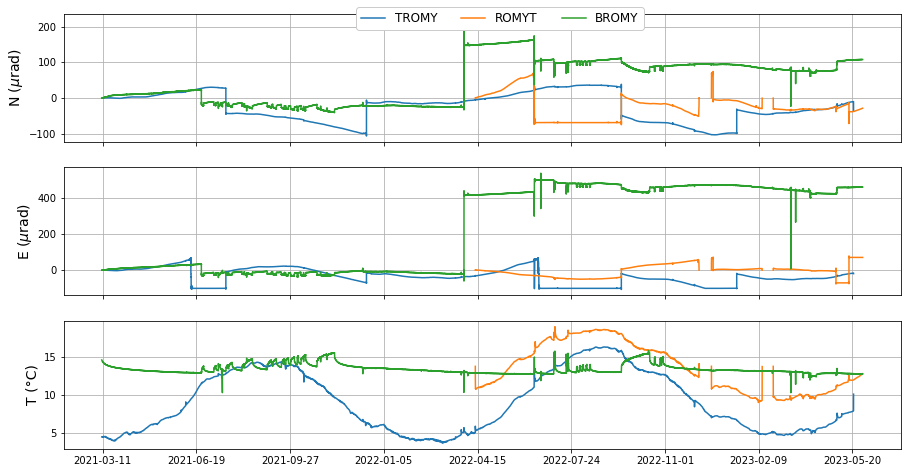

In [35]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)

## Correct for Linear Temperature Trend

In [ ]:
def __correct_temperature_trend(st, correction):
    
    st0 = st.copy()
    temperature = st0.select(channel="*T")[0].data
    
#     st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
#     st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
    st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)
    
    return st0

In [ ]:
## apply correction model
# TROMY = __correct_temperature_trend(TROMY, temperature_correction['TROMY'])
# ROMYT = __correct_temperature_trend(ROMYT, temperature_correction['ROMYT'])
# BROMY = __correct_temperature_trend(BROMY, temperature_correction['BROMY'])

In [ ]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)

In [ ]:
ROMYT.plot(equal_scale=False)

## Add WROMY Data

In [ ]:
from andbro__load_WROMY_stream import __load_wromy_stream

In [ ]:
ws5 = __load_wromy_stream(config['path_to_data'], "BW.WROMY..WS4", config['tbeg'], config['tend'])

In [ ]:
from numpy import isfinite, array
import numpy.ma as ma

arr = ws5.select(channel="*T")[0].data
# arr = array([1,2,3,nan,3,4])
# mask = isfinite(arr)
# ma_arr = ma.masked_array(arr, mask=mask)

ma_arr = ma.masked_invalid(arr)
ws5.select(channel="*T")[0].data = ma.masked_invalid(arr)

plt.plot(ma_arr)

### Load FURT Data

In [ ]:
from andbro__load_FURT_stream import __load_furt_stream

In [ ]:
def __load_furt_stream(config, show_raw=False, path_to_archive='/bay200/gif_online/FURT/WETTER/'):
    
    '''
    Load a selection of data of FURT weather station for certain times and return an obspy stream
    
    
    PARAMETERS:
        - config:    configuration dictionary
        - show_raw:  bool (True/False) -> shows raw data FURT head


    RETURN:
        - stream
        
    '''
    
    from pathlib import Path
    from obspy import UTCDateTime
    from tqdm.notebook import tqdm_notebook
    from numpy import arange
    from obspy import Stream
    
    def __add_trace(cha, tbeg, dat, dt=1):

        from obspy import Trace, UTCDateTime
        from numpy import array

        tr = Trace()
        tr.stats.station = 'FURT'
        tr.stats.channel = str(cha)
        tr.stats.sampling_rate = 1/dt
        tr.stats.starttime = UTCDateTime(tbeg)
        tr.data = array(dat)

        return tr
    
    
    def __resample(df, freq='1S'):

        ## make column with datetime
        df['datetime'] = df['date'].astype(str).str.rjust(6,"0")+" "+df['time'].astype(str).str.rjust(6,"0")

        ## drop datetime duplicates
        df = df[df.duplicated("datetime", keep="first") != True]

        ## convert to pandas datetime object
        df['datetime'] = pd.to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="coerce")

        ## set datetime column as index
        df.set_index('datetime', inplace=True)

        ## remove duplicates
        df = df[~df.index.duplicated()]

        ## resample
        df = df.asfreq(freq=freq)

        return df 
    

    
    config['tbeg'] = UTCDateTime(config['tbeg'])
    config['tend'] = UTCDateTime(config['tend'])
    
    output_text = []
    
    new_delta = 10
    
    if not Path(path_to_archive).exists():
        output_text.append(f"  -> Path: {path_to_archive}, does not exists!")
#         print(f"  -> Path: {path_to_archive}, does not exists!")
        return    
    
    
    ## list of parameters requried in configurations
    params = ['tbeg', 'tend']
    for param in params:
        if not param in config.keys():
            output_text.append(f"ERROR: {param} not in config but required!")
#             print(f"ERROR: {param} not in config but required!")
            return
    
    
    ## declare empyt dataframe
    df = pd.DataFrame()
    
    for i, date in enumerate(tqdm_notebook(arange(config['tbeg'].date, (config['tend']+86410).date))):
        
        date = UTCDateTime(str(date)).date
        filename = f'FURT.WSX.D.{str(date.day).rjust(2,"0")}{str(date.month).rjust(2,"0")}{str(date.year).rjust(2,"0")[-2:]}.0000'
        
#         print(f'   reading {filename} ...')

        try:
            if show_raw:
                df0 = pd.read_csv(path_to_archive+filename)            
                print(df0.columns.tolist())
                return
            else:
                df0 = pd.read_csv(path_to_archive+filename, usecols=[0,1,10,12,13,14], names=['date', 'time', 'T', 'H', 'P','Rc'])            
            
            ## substitute strings with floats
            df0['T']  = df0['T'].str.split("=", expand=True)[1].str.split("C", expand=True)[0].astype(float)
            df0['P']  = df0['P'].str.split("=", expand=True)[1].str.split("H", expand=True)[0].astype(float)
            df0['H']  = df0['H'].str.split("=", expand=True)[1].str.split("P", expand=True)[0].astype(float)
            df0['Rc'] = df0['Rc'].str.split("=", expand=True)[1].str.split("M", expand=True)[0].astype(float)
           
            
            ## replace error indicating values (-9999, 999.9) with NaN values
#             df0.replace(to_replace=-9999, value=nan, inplace=True)
#             df0.replace(to_replace=999.9, value=nan, inplace=True)
            
            
            if df.empty:
                df = df0
            else: 
                df = pd.concat([df, df0])
        except:
            output_text.append(f"  -> File: {filename}, does not exists!")
#             print(f"  -> File: {filename}, does not exists!")
   
    ## reset the index for the joined frame
    df.reset_index(inplace=True, drop=True)

    
    ## resample dataframe and avoid data gaps
    df = __resample(df, freq=f'{new_delta}S')

    
    for text in output_text:
        print(text)    

    df_starttime = UTCDateTime(df.index[0])
    
    ## create stream and attach traces
    st0 = Stream()
    st0 += __add_trace("LAT", df_starttime, df['T'], dt=new_delta)
    st0 += __add_trace("LAP", df_starttime, df['P'], dt=new_delta)
    st0 += __add_trace("LAH", df_starttime, df['H'], dt=new_delta)
    st0 += __add_trace("LAR", df_starttime, df['Rc'], dt=new_delta)
        
    ## trim to specfied time period
    st0.trim(config['tbeg'], config['tend'])
        
    print(f"Specified end: {config['tend']} \nTrace end:     {st0.select(channel='LAT')[0].stats.endtime}")
    
    return st0

In [ ]:
furt = __load_furt_stream(config)

## Plotting 

## Tilt Vector

In [ ]:
def __get_vector(N, E, Twin=3600):

    from numpy import median, sqrt, arctan, degrees, mod, array, append, rad2deg

    
    dt = N[0].stats.delta
    t1 = N[0].stats.starttime
    t1 = 0

    Ndata = N[0].data
    Edata = E[0].data

    vnorm, vdir, timeline = [], [], []
    while (t1 + Twin*dt) < N[0].stats.npts:


        Nmed = median(Ndata[int(t1*dt):int((t1+Twin)*dt)])
        Emed = median(Edata[int(t1*dt):int((t1+Twin)*dt)])

        vnorm.append(sqrt(Nmed**2 + Emed**2))
    #     vdir.append(mod(degrees(arctan(Nmed/Emed)), 360))
        vdir.append(rad2deg(arctan(Nmed/Emed)))

        t1 += Twin/2*dt
    
        timeline.append(t1*dt)
    
    
    time_offset = N[0].stats.starttime.hour*3600+ N[0].stats.starttime.minute*60 + N[0].stats.starttime.second
    timeline = ( array(timeline) + time_offset ) / 3600 /24 # in hours
    
    return timeline, array(vdir), array(vnorm)

bt_vtimeline, bt_vdir, bt_vnorm = __get_vector(bt.select(channel="*N"), bt.select(channel="*E"), Twin=3600)
pt_vtimeline, pt_vdir, pt_vnorm = __get_vector(pt.select(channel="*N"), pt.select(channel="*E"), Twin=3600)

In [ ]:
def __get_movement(N, E, Twin=3600):

    from numpy import median, sqrt, arctan, degrees, mod, array, append, rad2deg, nan
    from numpy import ma
    
    dt = N[0].stats.delta
#     t1 = N[0].stats.starttime
    t1 = 0

    Ndata = N[0].data
    Edata = E[0].data

    if ma.is_masked(Ndata):
        Ndata = ma.filled(Ndata, fill_value=nan)
    if ma.is_masked(Edata):
        Edata = ma.filled(Edata, fill_value=nan)
        
    vnorm, vdir, timeline = [], [], []
    while (t1 + Twin) < N[0].stats.npts*dt:
        
        Nmed = median(Ndata[int(t1/dt):int((t1+Twin)/dt)])
        Emed = median(Edata[int(t1/dt):int((t1+Twin)/dt)])

        
        vnorm.append(sqrt(Nmed**2 + Emed**2))
        
        if Nmed > 0 and Emed > 0:
            vdir.append(90-abs(rad2deg(arctan(abs(Nmed/Emed)))))
        
        elif Nmed < 0 and Emed > 0:
            vdir.append(90+abs(rad2deg(arctan(abs(Nmed/Emed)))))
        
        elif Nmed < 0 and Emed < 0:
            vdir.append(270-abs(rad2deg(arctan(abs(Nmed/Emed)))))
        
        elif Nmed > 0 and Emed < 0:
            vdir.append(270+abs(rad2deg(arctan(abs(Nmed/Emed)))))
        
        else:
            vdir.append(nan)
            
        t1 += Twin/2
    
        timeline.append(t1)
    
    time_offset = N[0].stats.starttime.julday
    timeline = array(timeline)/3600 /24 + time_offset# in days
    
    return timeline, array(vdir), array(vnorm)

In [ ]:
def __makeplot_normal_vector_movement(vdirH, vnormH, vdirV, vnormV, vtimelineH, vtimelineV):
    
    #-- Plot... ------------------------------------------------
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(15,5))

    font=12


    p1 = ax[0].scatter(deg2rad(vdirH), vnormH, c=vtimelineH, cmap='plasma', alpha=0.75, s=4, zorder=2)
    p2 = ax[1].scatter(deg2rad(vdirV), vnormV, c=vtimelineV, cmap='plasma', alpha=0.75, s=4, zorder=2)

    cbar1 = plt.colorbar(p1, ax=ax[0], pad=0.1)
    cbar1.set_label('Time in days', rotation=270, fontsize=font, labelpad=18)

    cbar2 = plt.colorbar(p2, ax=ax[1],  pad=0.1)
    cbar2.set_label('Time in days of 2021', rotation=270, fontsize=font, labelpad=18)


#     ax[0].set_ylim(min(vnormH)-0.1*min(vnormH), max(vnormH)+0.05*max(vnormH))

#     ax[1].set_ylim(min(vnormV)-0.05*min(vnormV), max(vnormV)+0.01*max(vnormV))

    ax[0].set_ylim(0.15, 0.18)
    ax[1].set_ylim(0.2, 0.24)

    ax[0].set_theta_zero_location('N')
    ax[0].set_theta_direction(-1)

    ax[1].set_theta_zero_location('N')
    ax[1].set_theta_direction(-1)
    
    ax[0].text(deg2rad(25),93,r"$\mu$rad")
    ax[1].text(deg2rad(25),93,r"$\mu$rad")
    
#     ax[0].set_rgrids(arange(15, 50, 5), angle=60., zorder=0)
#     ax[1].set_rgrids(arange(22.5, 40.0, 2.5), angle=60., zorder=0)

    ax[0].set_title("Platform Tiltmeter",fontsize=font)
    ax[1].set_title("Borehole Tiltmeter",fontsize=font)

In [ ]:
def __makeplot_vector(vdirH, vnormH, vdirV, vnormV, vtimelineH, vtimelineV):
    
    N = 2
    font = 12
 
    fig, ax = plt.subplots(N, 2, figsize=(15,6), sharex=True)
    
#     ax[0][0].plot(vtimelineH, vnormH)
    ax[0][0].scatter(vtimelineH, vnormH, c=vtimelineH, cmap="plasma", s=0.7)
    
#     ax[0][1].plot(vtimelineV, vnormV)
    ax[0][1].scatter(vtimelineV, vnormV, c=vtimelineH, cmap="plasma", s=0.7)
    
#     ax[1][0].plot(vtimelineH, vdirH)
    ax[1][0].scatter(vtimelineH, vdirH, c=vtimelineH, cmap="plasma", s=0.7)

#     ax[1][1].plot(vtimelineV, vdirV)
    ax[1][1].scatter(vtimelineV, vdirV, c=vtimelineH, cmap="plasma", s=0.7)
   
    ax[0][0].grid(zorder=0, alpha=0.7, color="grey", ls=":")
    ax[0][1].grid(zorder=0, alpha=0.7, color="grey", ls=":")
    ax[1][0].grid(zorder=0, alpha=0.7, color="grey", ls=":")
    ax[1][1].grid(zorder=0, alpha=0.7, color="grey", ls=":")
    
    ax[0][0].set_title('Platform Tiltmeter', fontsize=font)
    ax[0][1].set_title('Borehole Tiltmeter', fontsize=font)
    
    ax[0][0].set_ylabel("Vector Norm (mrad)", fontsize=font)
    ax[1][0].set_ylabel("Degrees (°)", fontsize=font)
    
    ax[N-1][0].set_xlabel("Day of Year", fontsize=font)
    ax[N-1][1].set_xlabel("Day of Year", fontsize=font)
    
    return fig

In [ ]:
from numpy import deg2rad

vtimelineH, vdirH, vnormH = __get_movement(pt.select(channel="*N"), pt.select(channel="*E"), Twin=3600)
vtimelineV, vdirV, vnormV = __get_movement(bt.select(channel="*N"), bt.select(channel="*E"), Twin=3600)

vnormH *= 1e3 # convert to milli rad
vnormV *= 1e3 # convert to milli rad

In [ ]:
__makeplot_normal_vector_movement(vdirH, vnormH, vdirV, vnormV, vtimelineH, vtimelineV)

In [ ]:
__makeplot_vector(vdirH, vnormH, vdirV, vnormV, vtimelineH, vtimelineV);

## Other

In [ ]:
def __read_furt_data(config, show_raw=False):
    '''
    Load a selection of data of FURT weather station for time period
    
    
    PARAMETERS:
        - config:    configuration dictionary
        - show_raw:  bool (True/False) -> shows raw data FURT head


    RETURN:
        - dataframe
        
    '''
    
    from tqdm import tqdm
    from numpy import arange
        
        
    ## define path_to_archive -> directory with data
    if 'path_to_archive' in config.keys():
        path_to_archive = config['path_to_archive']
    else:
        path_to_archive = '/bay200/gif_online/FURT/WETTER/'
        
    ## check if path with data exists
    if not Path(path_to_archive).exists():
        print(f"  -> Path: {path_to_archive}, does not exists!")
        return    
    
    
    ## list of parameters requried in configurations
    params = ['tbeg', 'tend']
    for param in params:
        if not param in config.keys():
            print(f"ERROR: {param} not in config but required!")
            return
    
    
    ## declare empyt dataframe
    df = pd.DataFrame()
    
    ## loop over day files and load data
    for i, date in tqdm(enumerate(arange(config['tbeg'].date, (config['tend']+86400).date))):
        
        date = UTCDateTime(str(date)).date
        filename = f'FURT.WSX.D.{str(date.day).rjust(2,"0")}{str(date.month).rjust(2,"0")}{str(date.year).rjust(2,"0")[-2:]}.0000'
        
#         print(f'   reading {filename} ...')

        try:
            if show_raw:
                df0 = pd.read_csv(path_to_archive+filename)            
                print(df0.columns.tolist())
                return
            else:
                df0 = pd.read_csv(path_to_archive+filename, usecols=[0,1,10,12,13,14], names=['date', 'time', 'T', 'H', 'P','Rc'])            
            
            ## substitute strings with floats
            df0['T']  = df0['T'].str.split("=", expand=True)[1].str.split("C", expand=True)[0].astype(float)
            df0['P']  = df0['P'].str.split("=", expand=True)[1].str.split("H", expand=True)[0].astype(float)
            df0['H']  = df0['H'].str.split("=", expand=True)[1].str.split("P", expand=True)[0].astype(float)
            df0['Rc'] = df0['Rc'].str.split("=", expand=True)[1].str.split("M", expand=True)[0].astype(float)
           
            
            ## replace error indicating values (-9999, 999.9) with NaN values
            df0.replace(to_replace=-9999, value=nan, inplace=True)
            df0.replace(to_replace=999.9, value=nan, inplace=True)
            
            
            if df.empty:
                df = df0
            else: 
                df = pd.concat([df, df0])
        except:
            print(f"  -> File: {filename}, does not exists!")
   
    df.reset_index(inplace=True, drop=True)
        
    return df

In [ ]:
def __processing_FURT(data, config):
    
    filter_length = 10*config['resample']
    
    data.iloc[:,3:6] = data.iloc[:,3:6].rolling(filter_length).mean() 
    print(f"Filter: rooling mean {filter_length}!")
    
    data = data[data.index % config['resample'] == 0]
    print(f"Resampling: keep every {config['resample']}nth sample!")
    
    return data

In [ ]:
FURT = __read_furt_data(config)

In [ ]:
## set column headers
FURT = FURT[['date', 'time', 'T', 'P', 'H', 'Rc']]

## resampling 
config['resample'] = 10
FURT = __processing_FURT(FURT, config)


## check if date column consists of integers
if str(FURT['date'].dtype) == 'float64':
    FURT['date'] = FURT['date'].astype('int')

    
## add a column with day of year
FURT['doy'] = [int(UTCDateTime(f'20{str(int(dat)).rjust(6,"0")[-2:]}-{str(int(dat)).rjust(6,"0")[-4:-2]}-{str(int(dat)).rjust(6,"0")[-6:-4]}').julday) for dat in FURT.date]

In [ ]:
from obspy.signal.freqattributes import spectrum
from numpy import hanning
from andbro__fft import __fft

import matplotlib.pyplot as plt
import obspy

In [ ]:

datapath = f"/home/andbro/freenas/romy_archive/2022/BW/ROMYT/MAN.D/*"

N = obspy.read(datapath);
N.merge(fill_value='interpolate')

datapath = f"/home/andbro/freenas/romy_archive/2022/BW/ROMYT/MAE.D/*"

E = obspy.read(datapath);
E.merge(fill_value='interpolate')


In [ ]:
TRII = obspy.Stream()
TRII += N
TRII += E

In [ ]:
TRII.plot();

In [ ]:
TRII

In [ ]:
def __makeplotStreamPSD(st, config):

    from scipy import fftpack
    from numpy import abs
    from scipy.signal import welch, hann


    nblock =  4096*100
    overlap = 1028
    win = hann(nblock, True)

    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        ff, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, 
                        window=win, noverlap=overlap, nfft=nblock,
                        scaling="density",
                        return_onesided=True)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times(),
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].loglog(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )


        
        axes[i,0].set_ylabel(r'$\Omega$ (rad/s)')    
        axes[i,1].set_ylabel(r'PSD (rad$^2$/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(1e-7,0.25)
#         axes[i,1].set_ylim(1e-12,1e-9)

    return fig

In [ ]:
config = {}

__makeplotStreamPSD(TRII, config);